In [213]:
# Written by Tyler Elliott
# Sourced from multiple tutorials and repositories, combined by myself

# Most of the deep q-learning agent code came from here: https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial

# Uses the MovieLens environment found here: https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/
# environments/movielens_py_environment/MovieLensPyEnvironment
# Most of the movielens environment manipulation comes from here: https://medium.com/@yuchengtsai84/reinforcement-
# learning-based-recommender-systems-using-tf-agent-and-movielens-dataset-ebbf40b3a1a2
# Although we took the framework from the above we created a trained a different agent on the same environment. Instead
# of LinearUCB we implemented a Deep Q-Learning Agent.

# Uses the tf_agents DQN Agent found here: https://www.tensorflow.org/agents/api_docs/python/tf_agents/agents/DqnAgent

# Knowledge of replay buffers from here: https://www.tensorflow.org/agents/tutorials/5_replay_buffers_tutorial
# Knowledge of trajectories from here:
# https://www.tensorflow.org/agents/api_docs/python/tf_agents/trajectories/Trajectory
# Knowledge of regret from here:
# https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/metrics/tf_metrics/RegretMetric
# Combining buffers and trajectories to train from here: https://www.tensorflow.org/agents/tutorials/bandits_tutorial
# The use of tf_agents QNetwork (which I ended up re-implementing manually instead) from here:
# https://www.tensorflow.org/agents/api_docs/python/tf_agents/networks/q_network/QNetwork
# The general concept of recommender RL from here:
# https://cloud.google.com/blog/topics/developers-practitioners/build-reinforcement-learning-recommendation-
# application-using-vertex-ai


In [214]:
import functools
from typing import List, Any, TypeVar

import tensorflow as tf
import tf_agents
from matplotlib import pyplot as plt
from tf_agents.agents.dqn import dqn_agent
from tf_agents.bandits.environments import environment_utilities
from tf_agents.bandits.environments import movielens_py_environment
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import TFEnvironment
from tf_agents.environments import tf_py_environment
from tf_agents.networks import sequential
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

import constant as const

T = TypeVar("T")


In [215]:
# Setup the environment using our experimental constant values
# The 2 is required for DQN Agents as seen here:
# https://www.tensorflow.org/agents/api_docs/python/tf_agents/agents/TFAgent
def define_rl_environment() -> TFEnvironment:
    env = movielens_py_environment.MovieLensPyEnvironment(
        const.DATA_PATH, const.RANK_K, 2, num_movies=const.NUM_ACTIONS, csv_delimiter="\t")
    environment = tf_py_environment.TFPyEnvironment(env)
    return environment

In [216]:
# Use a regret metric to determine improvement over training
# Taken from the movielens environment tutorial
def define_rl_metric(environment: TFEnvironment) -> List[Any]:
    optimal_reward_fn = functools.partial(
        environment_utilities.compute_optimal_reward_with_movielens_environment,
        environment=environment)
    regret_metric = tf_bandit_metrics.RegretMetric(optimal_reward_fn)
    metrics = [regret_metric]
    return metrics

In [217]:
env = define_rl_environment()
metric = define_rl_metric(env)

In [218]:
print('Observation Spec:')
print(env.time_step_spec().observation)

print('Reward spec')
print(env.reward_spec())

print('Action spec')
print(env.action_spec())

Observation Spec:
TensorSpec(shape=(20,), dtype=tf.float64, name='observation')
Reward spec
TensorSpec(shape=(), dtype=tf.float32, name='reward')
Action spec
BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0), maximum=array(19))


In [219]:
print('action_spec:', env.action_spec())
print('time_step_spec.observation:', env.time_step_spec().observation)
print('time_step_spec.step_type:', env.time_step_spec().step_type)
print('time_step_spec.discount:', env.time_step_spec().discount)
print('time_step_spec.reward:', env.time_step_spec().reward)

action_spec: BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0), maximum=array(19))
time_step_spec.observation: TensorSpec(shape=(20,), dtype=tf.float64, name='observation')
time_step_spec.step_type: TensorSpec(shape=(), dtype=tf.int32, name='step_type')
time_step_spec.discount: BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32))
time_step_spec.reward: TensorSpec(shape=(), dtype=tf.float32, name='reward')


In [220]:
# From the tf-agents DQN agent tutorial, initializing the q_value neural network itself

fc_layer_params = (60, 40)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1


# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
    return tf.keras.layers.Dense(
        num_units,
        activation=tf.keras.activations.relu,
        kernel_initializer=tf.keras.initializers.VarianceScaling(
            scale=2.0, mode='fan_in', distribution='truncated_normal'))


# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [221]:
# tf_agents QNetwork instead of the custom one above (found to be less effective)
fc_layer_params = (60, 40)
input_tensor_spec = tensor_spec.from_spec(env.observation_spec())
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

tf_q_net = tf_agents.networks.q_network.QNetwork(input_tensor_spec, action_tensor_spec)

In [222]:
# Initialiaze the DQN agent, taken from the tf-agents tutorial on using DQN agents
learning_rate = 1e-3

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    env.time_step_spec(),
    env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

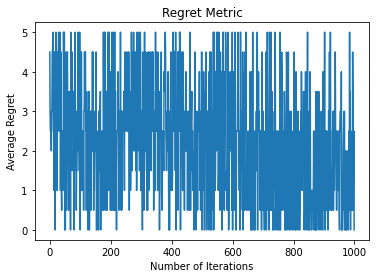

In [223]:
# Taken from https://www.tensorflow.org/agents/tutorials/bandits_tutorial and made to fit our scenario and environment

# define our regret metric
regret_metric = define_rl_metric(env)[0]

# experimental params
# steps_per_loop and batch_size must be 2 because it as DQN Agent
num_iterations = 1000
steps_per_loop = 2
batch_size = 2

# replay buffer to store experience in the form of trajectories
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.policy.trajectory_spec,
    batch_size=batch_size,
    max_length=steps_per_loop)

# the tracking metrics we will use
observers = [replay_buffer.add_batch, regret_metric]

# a driver to push the agent forward in exploration of the environment
driver = dynamic_step_driver.DynamicStepDriver(
    env=env,
    policy=agent.collect_policy,
    num_steps=steps_per_loop * batch_size,
    observers=observers)

regret_values = []

for _ in range(num_iterations):
    # start the driver
    driver.run()
    # begin training the agent based on all of the trajectories in the buffer
    loss_info = agent.train(replay_buffer.gather_all())
    replay_buffer.clear()
    # track how our regret metric is changing
    regret_values.append(regret_metric.result())

plt.plot(regret_values)
plt.title('Regret Metric')
plt.ylabel('Average Regret')
plt.xlabel('Number of Iterations')
plt.savefig('Regret values')